### Import packages

In [30]:
import sqlite3
import pandas as pd
import json
from itertools import chain
from random import sample
import numpy as np
import os
from bs4 import BeautifulSoup
import string
import re
import fasttext

import urllib.request as req
from reportlab.lib.enums import TA_JUSTIFY, TA_CENTER
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.units import cm
from reportlab.lib import utils
from reportlab.lib.styles import ParagraphStyle

### Query database

In [31]:
conn = sqlite3.connect("gfm.db")
feed = pd.read_sql_query("SELECT * FROM feed_tb", conn)

### Remove non-English campaigns

In [32]:
feed = feed.drop_duplicates('url')
feed['fund_description'] = [x.replace('\n','') for x in feed['fund_description']]
feed['nchar']= [len(x) for x in feed['fund_description']]
feed = feed[feed['nchar'] >= 100]

In [33]:
def GetLanguage(df):
    path_to_pretrained_model = 'fasttext_models/lid.176.bin'
    fmodel = fasttext.load_model(path_to_pretrained_model)
    r = fmodel.predict(feed['fund_description'].to_list())
    labels = r[0]
    labels = [i[0].split('__')[2] for i in labels]
    scores = r[1]
    scores = [i[0] for i in scores]
    return labels, scores

In [34]:
feed['language'], feed['lang_score'] = GetLanguage(feed)

In [35]:
feed = feed[feed['language'] == 'en']

In [36]:
len(feed)

89676

### Clean text

In [37]:
feed['fund_description'] = [x.replace('\xa0','') for x in feed['fund_description']]

### Identify super earners

In [38]:
feed.loc[:,'earner_category'] = np.where(feed['current_amount'] > 100_000, 'se', 'non_se')

In [39]:
se = feed[feed['earner_category'] == 'se']

In [40]:
non_se = feed[feed['earner_category'] == 'non_se']

### How much do super earners ask for?

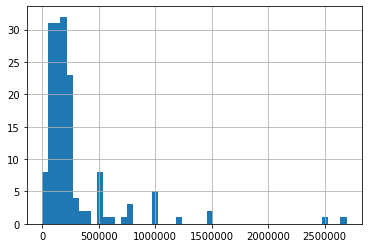

In [41]:
se['goal_amount'].hist(bins=50)

In [42]:
se['goal_amount'].quantile([0,.25,.5,.75, 1])

0.00        100.0
0.25     110000.0
0.50     187000.0
0.75     250000.0
1.00    2695000.0
Name: goal_amount, dtype: float64

### Control group # 1: Super earner fails

- First, we will assign super earners to a goal amount quartile
- Second, we will randomly sample 2x campaigns in that goal amount quartile who make < 100_000 and start within 6 months of corresponding super earner

In [43]:
se['quart'] = pd.qcut(se['goal_amount'], 4, labels=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
from copy import deepcopy
from dateutil.relativedelta import relativedelta

In [49]:
def GetControl1(se, non_se):
    #define results container to store urls of control campaigns
    r = []
    #define copy of non_se pool
    non_se_copy = deepcopy(non_se)
    #ensure dates are properly formatted
    se.loc[:,'launch_date'] = pd.to_datetime(se['launch_date'], utc=True)  
    non_se_copy.loc[:,'launch_date'] = pd.to_datetime(non_se_copy['launch_date'], utc=True) 
    #loop through SE campaigns, sample
    for index, row in se.iterrows():
        quart = row['quart']
        date = row['launch_date']
        #get subset of candidate campaigns based on goal amount quartile
        if quart == 0:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 100) & (non_se_copy['goal_amount'] <= 110000)]
        elif quart == 1:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 110000) & (non_se_copy['goal_amount'] <= 187000)]
        elif quart == 2:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 187000) & (non_se_copy['goal_amount'] <= 250000)]
        elif quart == 3:
            cand = non_se_copy[(non_se_copy['goal_amount'] > 250000) & (non_se_copy['goal_amount'] <= 2695000)]
        #subset candidate campaigns based on launch date
        six_mo_before = date + relativedelta(months=-3)
        six_mo_after = date + relativedelta(months=+3)
        date_mask = (cand['launch_date'] >= six_mo_before) & (cand['launch_date'] <= six_mo_after)
        cand = cand.loc[date_mask]
        if len(cand) < 2:
            print('no candidates for {0}'.format(row['url']))
            continue
        #sample candidate campaigns 2:1
        cand = cand.sample(2)
        #store urls in results container
        [r.append(url) for url in cand['url'].tolist()]
        #remove urls in results from candidate pool
        non_se_copy = non_se_copy[~non_se_copy['url'].isin(r)]

    return r

In [50]:
con_1_urls = GetControl1(se, non_se)

In [51]:
con_1 = non_se[non_se['url'].isin(con_1_urls)]

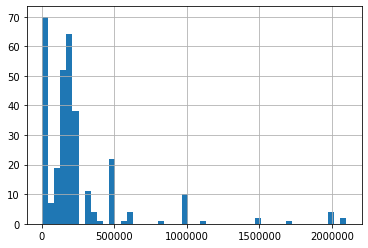

In [52]:
con_1['goal_amount'].hist(bins=50)

### Control group # 2: Average campaign
- we will randomly sample 2x remaining campaigns that start within 6 months of corresponding super earner

In [53]:
def GetControl2(se, non_se):
    #define results container to store urls of control campaigns
    r = []
    #define copy of non_se pool
    non_se_copy = deepcopy(non_se)
    #ensure dates are properly formatted
    se.loc[:,'launch_date'] = pd.to_datetime(se['launch_date'], utc=True)  
    non_se_copy.loc[:,'launch_date'] = pd.to_datetime(non_se_copy['launch_date'], utc=True) 
    #loop through SE campaigns, sample
    for index, row in se.iterrows():
        date = row['launch_date']
        #subset candidate campaigns based on launch date
        six_mo_before = date + relativedelta(months=-3)
        six_mo_after = date + relativedelta(months=+3)
        cand = non_se_copy
        date_mask = (cand['launch_date'] >= six_mo_before) & (cand['launch_date'] <= six_mo_after)
        cand = cand.loc[date_mask]
        if len(cand) < 2:
            print('no candidates for {0}'.format(row['url']))
            continue
        #sample candidate campaigns 2:1
        cand = cand.sample(2)
        #store urls in results container
        [r.append(url) for url in cand['url'].tolist()]
        #remove urls in results from candidate pool
        non_se_copy = non_se_copy[~non_se_copy['url'].isin(r)]

    return r

In [54]:
con_2_urls = GetControl2(se, non_se[~non_se['url'].isin(con_1['url'].tolist())])

In [55]:
con_2 = non_se[non_se['url'].isin(con_2_urls)]

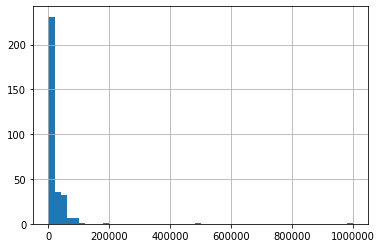

In [56]:
con_2['goal_amount'].hist(bins=50)

In [22]:
df = feed[feed['nchar'] > 5000].sample(1)

### Comparing goal amount distributions

Text(0, 0.5, 'Frequency')

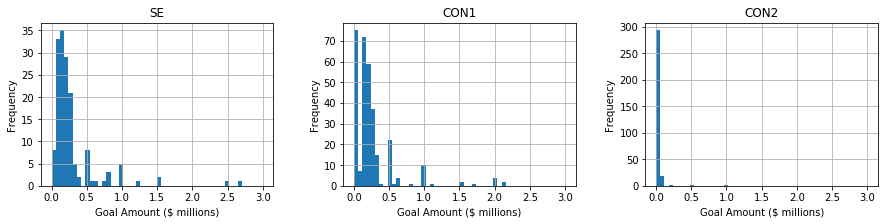

In [60]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15,3))

se.loc[:,'goal_amount_div'] = se['goal_amount']/1000000
con_1.loc[:,'goal_amount_div'] = con_1['goal_amount']/1000000
con_2.loc[:,'goal_amount_div'] = con_2['goal_amount']/1000000

se.hist('goal_amount_div', bins=50, ax=axes[0], range=[0, 3])
con_1.hist('goal_amount_div', bins=50, ax=axes[1], range=[0, 3])
con_2.hist('goal_amount_div', bins=50, ax=axes[2], range=[0, 3])

axes[0].set_title('SE')
axes[1].set_title('CON1')
axes[2].set_title('CON2')

axes[0].set_xlabel("Goal Amount ($ millions)")
axes[1].set_xlabel("Goal Amount ($ millions)")
axes[2].set_xlabel("Goal Amount ($ millions)")

axes[0].set_ylabel("Frequency")
axes[1].set_ylabel("Frequency")
axes[2].set_ylabel("Frequency")

In [62]:
print(se.shape)
print(con_1.shape)
print(con_2.shape)

(157, 72)
(314, 71)
(314, 71)


### Export data to save for future imports given that data are sampled

In [63]:
#se.to_csv('Super earners/data/super_earner.csv', index=False)
#con_1.to_csv('Super earners/data/control_1.csv', index=False)
#con_2.to_csv('Super earners/data/control_2.csv', index=False)

### Get sample of 20 campaigns for first round of review

In [65]:
frames = [se, con_1, con_2]
common_cols = list(set.intersection(*(set(df.columns) for df in frames)))

sample_20 = pd.concat([df[common_cols].sample(7) for df in frames], ignore_index=True).iloc[:20]

In [67]:
#sample_20.to_csv('Super earners/data/sample_20.csv', index=False)

### Download photos

In [68]:
def SavePhotos(feed):
    for index, row in feed.iterrows():
        url = row['default_url']
        imgurl = row['campaign_photo_url']
        req.urlretrieve(imgurl, "Super earners/photos/{0}.jpg".format(url))
    return "all done"

In [69]:
SavePhotos(sample_20)

'all done'

### Construct PDF

In [74]:
def AddTitle(doc, title):
    doc.append(Spacer(1,20))
    doc.append(Paragraph(title, ParagraphStyle(name='Name', fontSize=20, alignment=TA_CENTER)))
    doc.append(Spacer(1,50))
    return doc

In [75]:
def AddParagraph(doc, desc):
    soup = BeautifulSoup(desc)
    text = soup.get_text(separator="\n")
    for line in text.split('\n'):
        doc.append(Paragraph(line, ParagraphStyle(name='Name', fontSize=11)))
        doc.append(Spacer(1,12))
    return doc

In [76]:
def GetImage(path, width=1*cm):
    img = utils.ImageReader(path)
    iw, ih = img.getSize()
    aspect = ih / float(iw)
    return Image(path, width=width, height=(width * aspect))

In [77]:
def MakePDF(feed):
    for index, row in feed.iterrows():
        img_url = row['default_url']
        title = row['fund_name']
        desc = row['fund_description']
        document = []
        document.append(GetImage('Super earners/photos/{0}.jpg'.format(img_url), width=10*cm))
        document = AddTitle(document, title)
        SimpleDocTemplate('Super earners/pdfs/{0}.pdf'.format(img_url), 
                          pagesize=letter,
                          rightMargin=24,
                          leftMargin=24,
                          topMargin=24,
                          bottomMargin=24
                         ).build(AddParagraph(document, desc))
    return "all done"

In [79]:
MakePDF(sample_20)

'all done'